In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [2]:
plt.rcParams['lines.linewidth'] = 1
# tweak colors cycle inthe plots
# here i make a list of colors, later I can use it to make custom cycles
default_colors_cycle = plt.rcParams['axes.prop_cycle']()
default_colors_arr = np.array([next(default_colors_cycle)['color'] for x in range(15)])


import umap
import neo

from ceciestunepipe.util.dimension import umapred as dim
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import data as dt


In [3]:
reload(et)
sess_par = {'bird': 'z_w12m7_20',
           'sess': '2020-11-04',
           'probe': 'probe_0',
           'sort': 'sort_4'} #'sort_4' is ks3 manually curated; 'auto_5' is ks3, no manual

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

sess_epochs = et.list_sgl_epochs(sess_par)


### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])
sort_folder = os.path.join(exp_struct['folders']['sort'])

2021-11-01 05:52:19,417 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20', 'raw': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04', 'sglx': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx', 'kwik': '/scratch/earneodo/z_w12m7_20/sglx/kwik/2020-11-04', 'processed': '/mnt/sphere/speech_bci/processed_data/z_w12m7_20/2020-11-04/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/z_w12m7_20/sglx/msort/2020-11-04', 'ksort': '/scratch/earneodo/z_w12m7_20/sglx/ksort/2020-11-04/sort_4', 'sort': '/mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/sort_4'}, 'files': {'par': '/scratch/earneodo/z_w12m7_20/sglx/ksort/2020-11-04/sort_4/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/rig.json', 'kwd': '/scratch/

In [4]:
# load the dict and make the df right away.

bout_dict_file = 'bout_dict_hvc_allunits.pkl'

bout_dict_path = os.path.join(sort_folder, bout_dict_file)

with open(bout_dict_path, 'rb') as fh:
    bout_dict = pickle.load(fh)


keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr', 'mic_arr', 'clu_id_arr']

bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)

bout_df['bout_id'] = bout_df['start_sample_nidq']

mot_len_ms = 550 # looked it up in sglx_pipe-sort_rasters-z_m12w7_20_pouli



In [5]:
# load hvc meta dict
meta_dict_path = os.path.join(sort_folder, 'hvc_meta_dict.pkl')
logger.info('saving the hvc meta dict to {}'.format(meta_dict_path))

with open(meta_dict_path, 'rb') as f:
    hvc_meta_dict = pickle.load(f)

hvc_meta_dict.keys()

2021-11-01 05:52:19,820 root         INFO     saving the hvc meta dict to /mnt/sphere/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/sort_4/hvc_meta_dict.pkl


dict_keys(['int', 'blur', 'sharp', 'pn'])

In [6]:
clu_pickle_path = os.path.join(sort_folder, 'clu_df.pickle')
clu_df = pd.read_pickle(clu_pickle_path)

clu_df.head(2)

,cluster_id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,main_chan,MSLabel,has_template,template,max_chans,main_7,main_wav_7,nucleus
3,3,2082.9,100.0,good,90.564789,0,0.0,1.104526,good,8441,0,0,good,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 1, 3, 4, 5, 7, 13, 9, 15, 10, 6, 8, 12,...","[0, 1, 2, 3, 4, 5, 7]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
6,6,2350.7,100.0,good,154.954834,4,40.0,3.162705,good,24170,0,0,good,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2, 3, 1, 6, 4, 7, 5, 8, 9, 10, 13, 12, 14,...","[0, 1, 2, 3, 4, 6, 7]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


### filter units

In [7]:
def filter_units(bout_df, clu_id_list):
    # assume all spk_arr in bout_df have the same clu_id_arr
    clu_id_arr = bout_df['clu_id_arr'][0] 
    clu_mask = [x in clu_id_list for x in clu_id_arr]
    
    bout_df['spk_arr'] = bout_df['spk_arr'].apply(lambda x: x[clu_mask])
    bout_df['clu_id_arr'] = bout_df['clu_id_arr'].apply(lambda x: x[clu_mask])
    return clu_mask



#### filter good only

In [8]:
# good_clu_id = clu_df.loc[clu_df['MSLabel'].isin(['good']), 'cluster_id'].values
# good_clu_id

# good_clu_mask = filter_units(bout_df, good_clu_id)

#### filter by manual metadata

In [9]:
meta_keys_keep = ['sharp', 'pn']
meta_keys_keep = ['pn']
meta_keys_keep = ['sharp']
manual_clu_id = np.concatenate([hvc_meta_dict[k] for k in meta_keys_keep])
good_clu_mask = filter_units(bout_df, manual_clu_id)

In [10]:
clu_id_arr = bout_df['clu_id_arr'][0]
clu_id_arr.shape

(19,)

### get spectrograms and rate-grams

In [11]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0', 'spk_arr', 'mic_arr', 'clu_id_arr', 't_pre_s', 't_post_s'])

#### get mot starts:ends for scaling


In [12]:
bout_df['len_ms']
min_bout_len = np.min(bout_df['len_ms'])

bout_df['t_scale'] = bout_df['len_ms']/min_bout_len 
min_bout_len

bout_df['len'] = bout_df['len_ms'] * bout_dict['s_f']
bout_df['len_scaled'] = bout_df['len'] / bout_df['t_scale']

In [13]:
bout_df['t_scale']

0    1.000000
1    1.000000
2    1.006652
3    1.013304
4    1.019956
5    1.070953
6    1.046563
7    1.053215
8    1.066519
9    1.079823
Name: t_scale, dtype: float64

In [14]:
# bout_df['mic_arr_res'] = bout_df.apply()

In [15]:
#bout_dict

In [16]:
s_f_wav = bout_dict['s_f']
bout_df['sxx_all'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), s_f_wav, 
                                                                         f_min=100, f_max=9000)
                                             )

bout_df['sxx'] = bout_df['sxx_all'].apply(lambda x: x[2])

In [17]:
s_f_ap_0 = bout_dict['s_f_ap_0']

bin_size_ms = 1
bin_size_sample = int(bin_size_ms * 0.001 *  s_f_ap_0)

bout_df['fr_arr'] =  bout_df['spk_arr'].apply(lambda x: pu.coarse(x, bin_size_sample))

#### show spectrograms

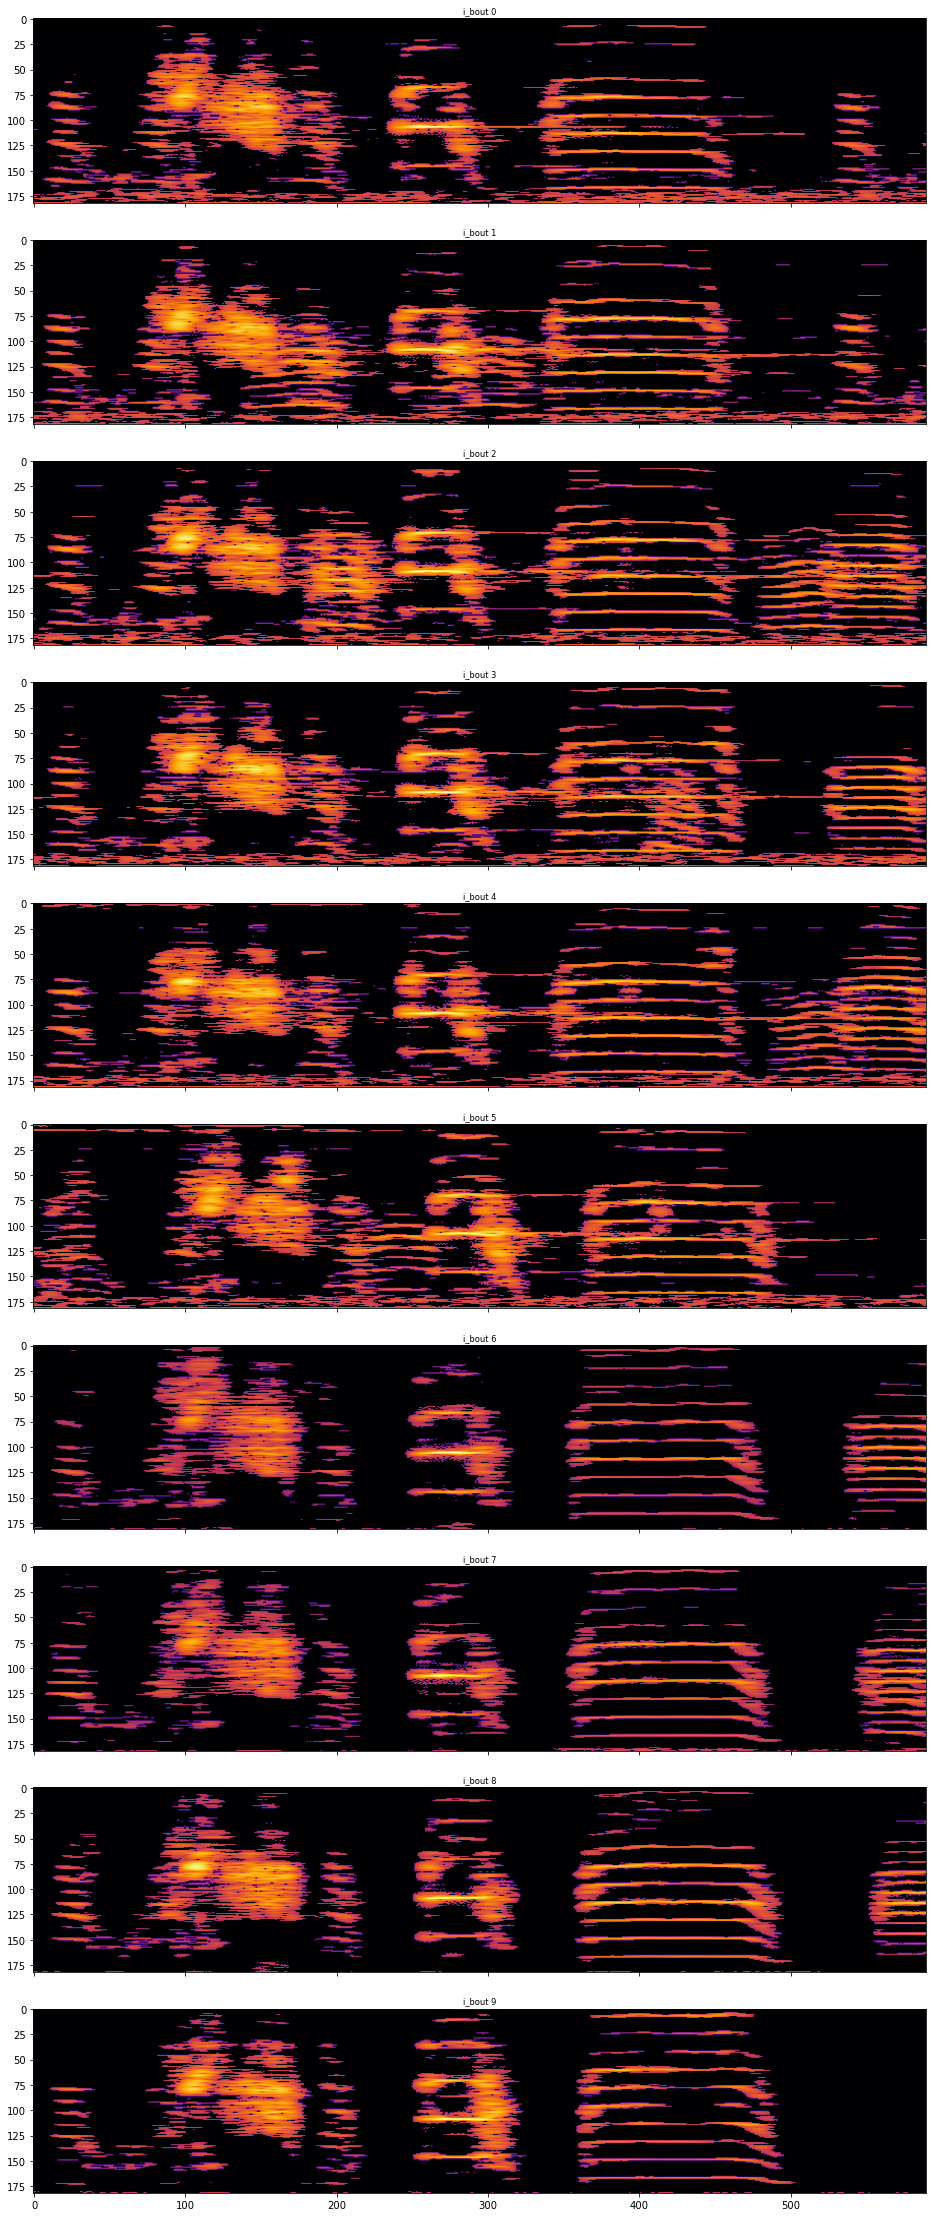

In [18]:
#show_bout = range(n_show)

show_bout = range(10)
n_show = len(show_bout) 
fig, ax = plt.subplots(nrows=n_show, figsize=(16, 4*n_show), sharex=True)

t_pre = bout_dict['t_pre_s']
mot_len_ms = 590

start_in_bout = int(np.abs(t_pre) * 1000) - 20 # in miliseconds, 20 is the spectrogram bin size
end_in_bout = int(start_in_bout + mot_len_ms) # in miliseconds

bout_df['sxx_chop'] = bout_df['sxx'].apply(lambda x: x[:, start_in_bout: end_in_bout])

for i_ax, i_bout in enumerate(show_bout):
    ax[i_ax].imshow(np.log(bout_df.iloc[i_bout]['sxx_chop'][::-1]), 
                    aspect='auto', 
                    cmap='inferno')
    ax[i_ax].set_title('i_bout {}'.format(i_bout))



In [19]:
## three different motifs (short: ends in silence -with the bout-, long: has an extra syllable, standard: ends with first syllable of next motif)
bout_dict['mot_kind'] = np.array([0, 0, 1, 1, 1, 2, 1, 1, 1, 2])
bout_df['mot_kind'] = bout_dict['mot_kind'] 

### gpfa for a bout

In [20]:
def spike_trains_from_bout(bout_s: pd.Series, s_f=30000):
    # get the bout spike array
    spk_arr = bout_s['spk_arr']
    
    # get the time of the spikes
    # make a neo SpikeTrain for each cluster
    t_stop = spk_arr.shape[1]/s_f
    spk_train_list = [neo.SpikeTrain(times=np.where(x==1)[0]/s_f, units='sec', t_stop=t_stop) for x in spk_arr]
    
    return spk_train_list

i_bout = 5
bout_spk_trains = spike_trains_from_bout(bout_df.iloc[i_bout])

# get thte spike trains for all bouts
all_bout_idx = list(bout_df.index)
all_spk_trains = [spike_trains_from_bout(bout_df.iloc[i_bout]) for i_bout in all_bout_idx]

### get also the spectrograms
all_spectrograms_list = [bout_df.iloc[i_bout]['sxx'] for i_bout in all_bout_idx]

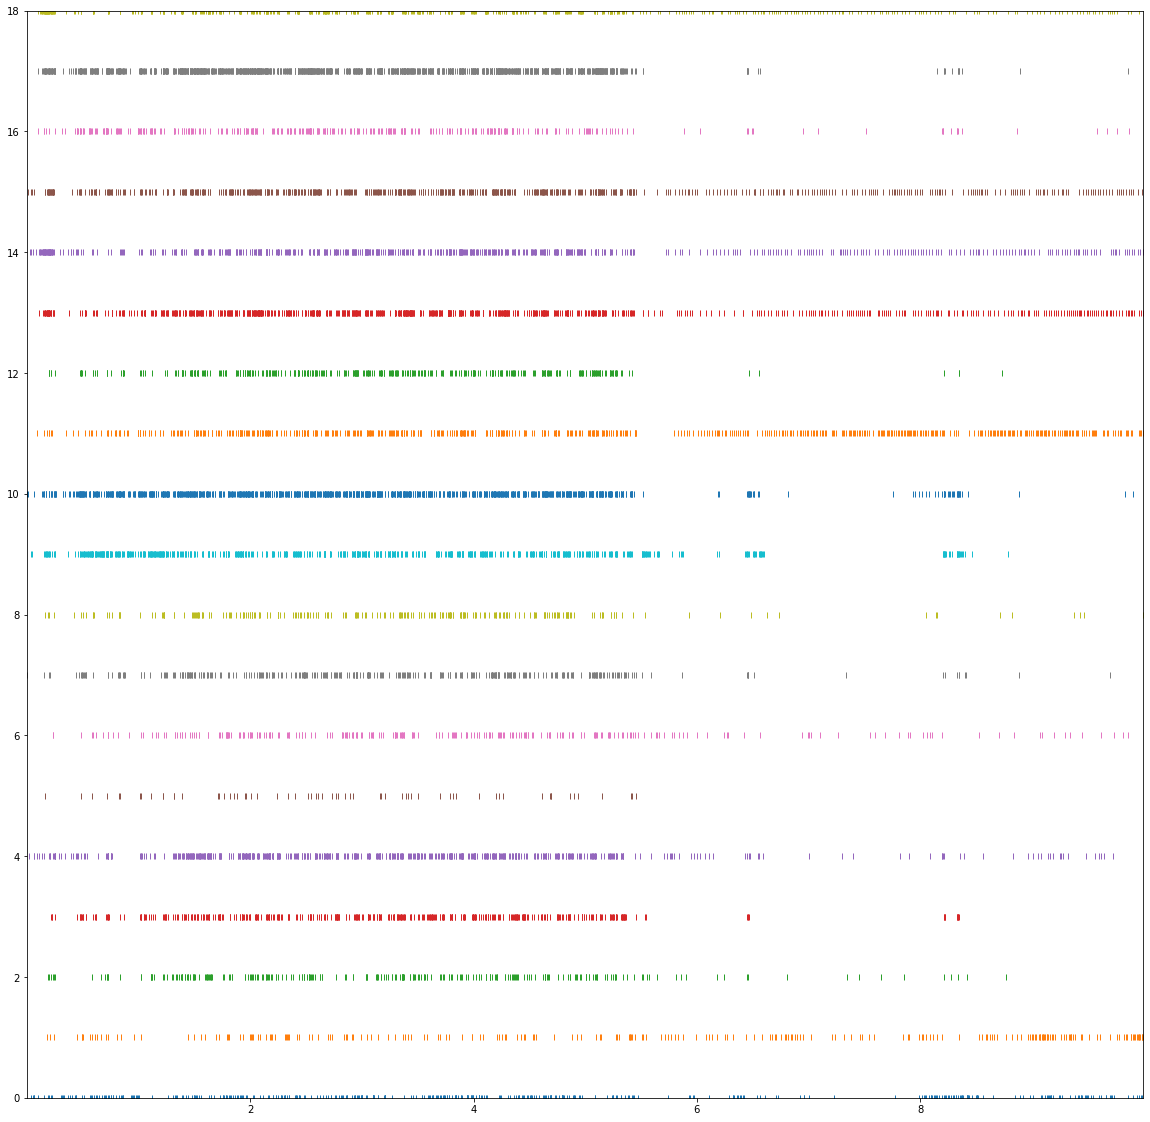

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))

for i, spiketrain in enumerate(bout_spk_trains):
    ax.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

In [22]:
import quantities as pq
from elephant.gpfa import GPFA

# specify fitting parameters
bin_ms = 10
bin_size = bin_ms * pq.ms

latent_dimensionality = 6

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [23]:
gpfa_2dim.fit(all_spk_trains)
print(gpfa_2dim.params_estimated.keys())

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 2 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '


Initializing parameters using factor analysis...

Fitting GPFA model...
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


#### get the trajectories for all the trials now

In [24]:
# get the trajectories for all the trials now
trial_trajectories = gpfa_2dim.transform(all_spk_trains)
# arrange them all into a single array [trial, latent_dim, bin]
trial_trajectories = np.stack(trial_trajectories, axis=0)
trial_trajectories.shape

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 2 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '


(10, 6, 1000)

#### chop all trayectories to the motif

In [25]:
mot_start_bin = int(start_in_bout / bin_ms)
mot_end_bin = int(end_in_bout / bin_ms)
mot_start_bin

498

In [26]:
(mot_end_bin - mot_start_bin) * bin_ms

590

In [27]:
# now it's easy to get the trajectories for the motifs
mot_trajectories = trial_trajectories[:, :, mot_start_bin: mot_end_bin]
mot_trajectories.shape

# and the average by 'kind' of motif
avg_traj = [np.median(mot_trajectories[bout_dict['mot_kind']==x], axis=0) for x in np.unique(bout_dict['mot_kind'])]
avg_traj_arr = np.stack(avg_traj, axis=0)

In [28]:
# tweak colors cycle inthe plots
# here i make a list of colors, later I can use it to make custom cycles

# make a cycle of 10 colors, ordered as the number of different kinds of motifs,
# so that each 'kind' will plot at a unique different color

colors_pick = default_colors_arr[[0, 2, 3]]
color_cycle_list = [colors_pick[i] for i in bout_dict['mot_kind']]

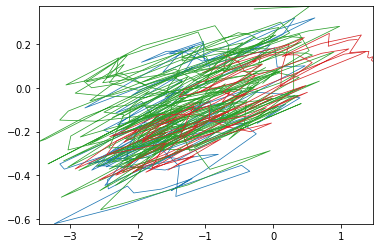

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=color_cycle_list)

for single_trial_trajectory in mot_trajectories[:]:
    ax.plot(single_trial_trajectory[0], single_trial_trajectory[2], '-', lw=0.75)

#ax.plot(avg_trajectories[0], avg_trajectories[1], 'c-.', lw=2);

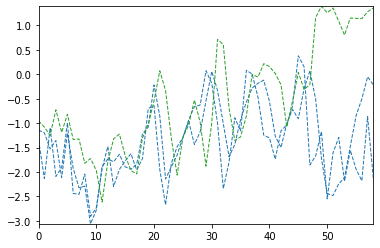

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=color_cycle_list)
ax.plot(avg_traj_arr[:, 0].T, '--')

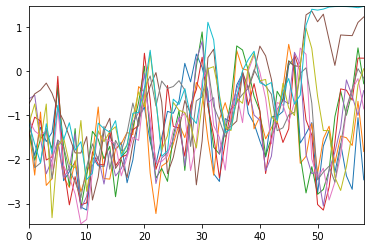

In [31]:
for i, mt in enumerate(mot_trajectories) :
    lc = 0
    plt.plot(mt[0]);

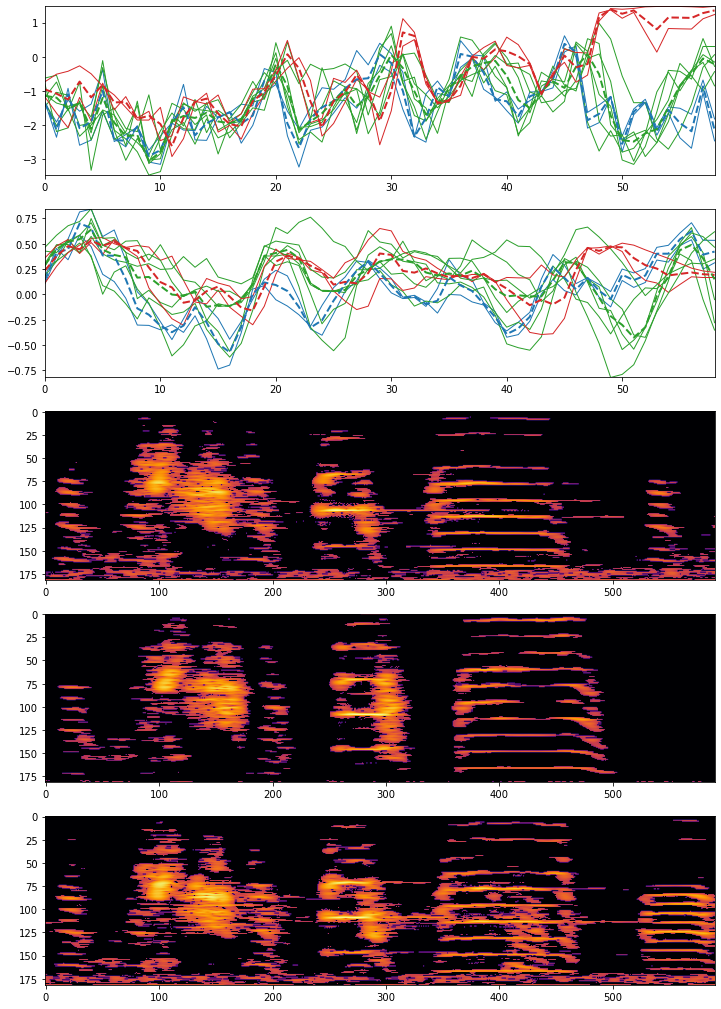

In [32]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 18))
#color_cycle = 
colors_pick = default_colors_arr[[0, 2, 3]]
color_cycle = [colors_pick[i] for i in bout_dict['mot_kind']] + list(colors_pick)

list(map(lambda x: x.set_prop_cycle(color=color_cycle), ax))

ax[0].plot(mot_trajectories[:, 0].T);
ax[0].plot(avg_traj_arr[:, 0].T, '--', lw=2)

ax[1].plot(mot_trajectories[:, 1].T);
ax[1].plot(avg_traj_arr[:, 1].T, '--', lw=2)

ax[2].imshow(np.log(bout_df.iloc[0]['sxx_chop'][::-1]), 
                    aspect='auto', 
                    cmap='inferno')
ax[3].imshow(np.log(bout_df.iloc[9]['sxx_chop'][::-1]), 
                    aspect='auto', 
                    cmap='inferno')
ax[4].imshow(np.log(bout_df.iloc[3]['sxx_chop'][::-1]), 
                    aspect='auto', 
                    cmap='inferno')

In [37]:
raise KeyboardInterrupt

KeyboardInterrupt: 

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '


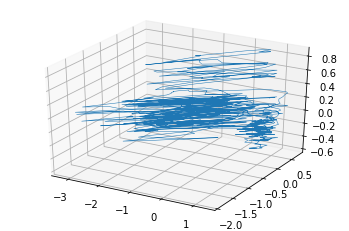

In [33]:
trajectories = gpfa_2dim.transform([all_spk_trains[1]])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for single_trial_trajectory in trajectories:
    ax.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2], '-', lw=0.5)

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '


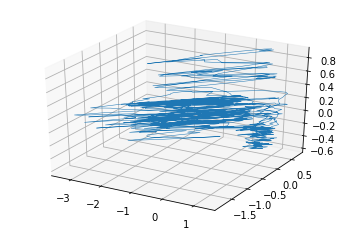

In [34]:
trajectories = gpfa_2dim.transform([all_spk_trains[2]])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for single_trial_trajectory in trajectories:
    ax.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2], '-', lw=0.5)

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/utils.py:290: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '


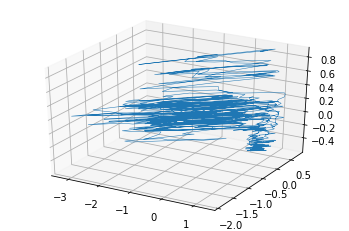

In [35]:
trajectories = gpfa_2dim.transform([all_spk_trains[3]])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for single_trial_trajectory in trajectories:
    ax.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2], '-', lw=0.5)

In [36]:
umap_win = 50
i_bout = 1

fr = bout_df.iloc[i_bout]['fr_arr']
reducer_fr, emb_fr, frflat = dim.rolling_umap(fr, umap_win, parametric=False, random_state=42)

sx = bout_df.iloc[i_bout]['sxx']
reducer, emb, rxflat = dim.rolling_umap(sx, umap_win, parametric=False, random_state=42)

KeyboardInterrupt: 

In [ ]:
plt.scatter(*emb.T, c=np.arange(emb.shape[0]), s=0.1, cmap='coolwarm');

In [ ]:
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='coolwarm');

In [ ]:
i_bout = 5

fr = bout_df.iloc[i_bout]['fr_arr']
reducer_fr, emb_fr, frflat = dim.rolling_umap(fr, umap_win, parametric=False, random_state=42)

sx = bout_df.iloc[i_bout]['sxx']
reducer, emb, rxflat = dim.rolling_umap(sx, umap_win, parametric=False, random_state=42)

In [ ]:
plt.scatter(*emb.T, c=np.arange(emb.shape[0]), s=0.1, cmap='cool');

In [ ]:
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [ ]:
plt.subplots(nrows=n_show, figsize=(16, 4*n_show)

In [ ]:
bout_df.head(1)

#### make many embeddings

In [ ]:
def make_umap_from_sample(bouts_df, feat='sxx', sample_size=0.3, window_size=20, some_bout_id=None):
    # some_bouts_id overrides sample size and uses a particular set of bouts for the embedding
    # pick some bouts
    # get the rolled spectrogram
    # make a umap embedding
    
    all_bout_id = bouts_df['bout_id'].values
    
    if some_bout_id is None:
        some_bout_id = np.random.choice(all_bout_id, int(all_bout_id.size * sample_size), 
                                        replace=False)
    
    bout_sel = bouts_df['bout_id'].isin(some_bout_id)
    
    logger.info('getting rolling {} for {} bouts'.format(feat, some_bout_id.size))
    
    roll_spec = lambda sx: dt.feature_flat(dt.rolling_window(sx, window_size)) 
    
    rolled_feat = 'rolled_' + feat
    bouts_df.loc[bout_sel, rolled_feat] = bouts_df.loc[bout_sel, feat].apply(roll_spec)
    
    logger.info('stacking em up')
    all_rolled_flat_feat = np.hstack(bouts_df.loc[bout_sel, rolled_feat])
    
    logger.info('making the embedding')
    reducer = umap.UMAP(random_state=42, low_memory=True)
    reducer.fit(all_rolled_flat_feat.T)
    logger.info('done')
    return reducer


def project_bouts(bouts_df, some_bout_id, reducer, window_size=20, feat='sxx'):
    ## do the rolling spectrogram and project for all of the some_bout_id
    bout_sel = bouts_df['bout_id'].isin(some_bout_id)
    
    logger.info('getting rolling {} umap projections for {} bouts'.format(feat, some_bout_id.size))
    roll_umap = lambda sx: dim.rolling_umap(sx, window_size, reducer)[1]
    
    logger.info('applying and making column rolled_umap_{}'.format(feat))
    bouts_df.loc[bout_sel, 'rolled_umap_{}'.format(feat)] = bouts_df.loc[bout_sel, feat].apply(roll_umap)
    bouts_df.loc[bout_sel, 'has_umap_'.format(feat)] = True
    
    return bouts_df

### pick these two particular bouts

In [ ]:
bout_i_list = [1, 5, 13]
bout_id_list = [bout_df.iloc[i]['bout_id'] for i in bout_i_list]

In [ ]:
### pick a random sample of bouts
umap_win = 50
n_sample = 2

#all_bout_id = bout_df['bout_id'].values

id_some_bout = np.array(bout_id_list)
#id_some_bout = np.random.choice(all_bout_id, n_sample, replace=False)

### make the projection with just this set of bouts
feature = 'sxx' # 'sxx' spectrogram, 'fr_arr' for firing rate. Both come in ms time step.

## save/load the reducer
reducer_path = os.path.join(exp_struct['folders']['derived'], 'reducer_{}.pkl'.format(feature))

sx_reducer = make_umap_from_sample(bout_df, some_bout_id=id_some_bout, window_size=umap_win)

with open(reducer_path, 'wb') as f:
    pickle.dump(sx_reducer, f)
logger.info('saved {} reducer to {}'.format(feature, reducer_path))
    
## or alternatively load reducer

In [ ]:
feature = 'sxx'
reducer_path = os.path.join(exp_struct['folders']['derived'], 'reducer_{}.pkl'.format(feature))
reducer_path

In [ ]:
bout_df = project_bouts(bout_df, id_some_bout, sx_reducer, window_size=umap_win)

In [ ]:
feature = 'fr_arr' # 'sxx' spectrogram, 'fr_arr' for firing rate. Both come in ms time step.
reducer_path = os.path.join(exp_struct['folders']['derived'], 'reducer_{}.pkl'.format(feature))

# maybe load reducer instead of computing it
fr_reducer = make_umap_from_sample(bout_df, feat=feature, some_bout_id=id_some_bout, window_size=umap_win)

#save reducer
with open(reducer_path, 'wb') as f:
    pickle.dump(fr_reducer, f)
logger.info('saved {} reducer to {}'.format(feature, reducer_path))


bout_df = project_bouts(bout_df, id_some_bout, fr_reducer, window_size=umap_win, feat=feature)

In [ ]:
### load/save the bouts with projected umap

In [ ]:

bout_df.to_pickle(umap_bout_df_path)
logger.info('saved bout_df to {}'.format(umap_bout_df_path))

In [ ]:
the_bout = bout_df.loc[bout_df['bout_id']==bout_id_list[0]]

emb_sx = the_bout['rolled_umap_sxx'].values[0]
emb_fr = the_bout['rolled_umap_fr_arr'].values[0]

plt.scatter(*emb_sx.T, c=np.arange(emb_sx.shape[0]), s=0.1, cmap='cool');
plt.figure()
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [ ]:
the_bout = bout_df.loc[bout_df['bout_id']==bout_id_list[1]]

emb_sx = the_bout['rolled_umap_sxx'].values[0]
emb_fr = the_bout['rolled_umap_fr_arr'].values[0]

plt.scatter(*emb_sx.T, c=np.arange(emb_sx.shape[0]), s=0.1, cmap='cool');
plt.figure()
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [ ]:
the_bout = bout_df.loc[bout_df['bout_id']==bout_id_list[2]]

emb_sx = the_bout['rolled_umap_sxx'].values[0]
emb_fr = the_bout['rolled_umap_fr_arr'].values[0]

plt.scatter(*emb_sx.T, c=np.arange(emb_sx.shape[0]), s=0.1, cmap='cool');
plt.figure()
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [ ]:
emb_fr = the_bout['rolled_umap_fr_arr'].values[0]
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [ ]:
for bout_id in bout_id_list:
    the_bout = bout_df.loc[bout_df['bout_id']==bout_id]
    
    bout_df.loc[bout_df['bout_id']][]

In [ ]:
def show_bout(bout_df, bout_id, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(16, 16))
        gs = fig.add_gridspec(4, 4)
        ax = []
        ax.append(fig.add_subplot(gs[0, :]))
        ax.append(fig.add_subplot(gs[1, :]))
        ax.append(fig.add_subplot(gs[2:, :2]))
        ax.append(fig.add_subplot(gs[2:, 2:]))
    
        
    the_bout = bout_df.loc[bout_df['bout_id']==bout_id]

    sx = the_bout['sxx'].values[0]
    emb_sx = the_bout['rolled_umap_sxx'].values[0]
    emb_fr = the_bout['rolled_umap_fr_arr'].values[0]

    ax[0].imshow(np.log(the_bout['sxx'].values[0][::-1]), aspect='auto', cmap='inferno');
    ax[1].imshow((the_bout['fr_arr'].values[0][::-1]), aspect='auto', cmap='inferno');
    
    ax[2].scatter(*emb_sx.T, c=np.arange(emb_sx.shape[0]), s=0.1, cmap='coolwarm');
    ax[3].scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='coolwarm');
                           
    return ax
                           
show_bout(bout_df, bout_id_list[0])

In [ ]:
show_bout(bout_df, bout_id_list[1])

In [ ]:
show_bout(bout_df, bout_id_list[2])

In [ ]:


# Topics: line, color, LineCollection, cmap, colorline, codex
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 



In [ ]:
sx.shape

In [ ]:
emb.shape

In [ ]:
t = np.arange(emb.shape[0])

x = emb.T[0]
y = emb.T[1]

fig, axes = plt.subplots(figsize=(6,6))

lc = colorline(x, y, alpha=0.75, cmap='coolwarm') 
# We can capture the LineCollection created to modify it later, e.g.:
# lc.set_rasterized = False

plt.xlim(x.min() - 0.1, x.max() + 0.1)
plt.ylim(y.min() - 0.1, y.max() + 0.1)

# plt.colorbar()  # Does not work at the moment!
plt.show()

In [ ]:
t = np.arange(emb.shape[0])

x = emb_fr.T[0]
y = emb_fr.T[1]

fig, axes = plt.subplots(figsize=(6,6))

lc = colorline(x, y, alpha=0.75, cmap='coolwarm') 
# We can capture the LineCollection created to modify it later, e.g.:
# lc.set_rasterized = False

plt.xlim(x.min() - 0.1, x.max() + 0.1)
plt.ylim(y.min() - 0.1, y.max() + 0.1)

# plt.colorbar()  # Does not work at the moment!
plt.show()

In [ ]:
x = np.linspace(0, 40.*np.pi, 10000)
y = np.sin(x)*x

fig, axes = plt.subplots()

colorline(x, y)

plt.xlim(x.min(), x.max())
plt.ylim(-1.0, 1.0)
plt.show()